# Web scraping for flats

Get some lists from ``leboncoin.fr``

In [1]:
import hashlib
import urllib
import unidecode
import numpy as np
from string import atof,atoi
from pprint import pprint
from bs4 import BeautifulSoup as BS
from datetime import datetime, timedelta

In [2]:
# ---------------------------------------
#             get the 1st 100
base_url='https://www.leboncoin.fr/locations/offres/ile_de_france/paris/'

# ----------------------------------------
#            a shortcut
urlget = urllib.urlopen

## Downlad page number 

The default search criteria are for flats with size > 30 sqm, in Paris.
The function returns the `Beautifulsoup`-ped HTML of a given page.
Each page contains a list of flats.

In [3]:
def get_page_from_url(pgnr,base_url):
    CL_paris_apa_html="{0:s}?o={1:d}&sqs=2&ret=1&ret=2&ret=5".format(base_url,pgnr)
    print CL_paris_apa_html
    try:
        xpage = urlget(CL_paris_apa_html)
        CL_html = xpage.read()
        encoding = xpage.info()['content-type'].split('=')[-1]
    except IOError: # in case of network error
        print 'IOError'
        CL_html = ''
    try:
        return BS(CL_html.decode(encoding,'replace'))
    except UnboundLocalError:
        return BS(CL_html.decode('latin-1','replace'))
human_page=get_page_from_url(2,base_url)

https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=2&sqs=2&ret=1&ret=2&ret=5


## List flats urls from page

From each page given by the previous function, we record the list of flats, their publication date, and pid.

In [4]:
def get_listings_from_html(human_page,base_url):
    today = datetime.now()
    yesterday = today - timedelta(days=1)
    yesterday = yesterday.strftime('%d/%m/%y')
    today = today.strftime('%d/%m/%y')

    apartments = human_page.findAll('a',attrs={'class':'list_item'})
    
    results=[]
    for item in apartments:
        try:
            title=unidecode.unidecode(''.join(item.select('h2.item_title')[0].contents).strip())
        except IndexError:
            continue
        insert_time = item.select('aside.item_absolute > p.item_supp')
        if not len(insert_time):
            continue
        insert_time = insert_time[0].contents[-1].strip().replace(u"Aujourd'hui",today)
        insert_time = insert_time.replace(u"Hier",yesterday)
        url = 'http:'+item.attrs['href']
        pid = url.split('/')[-1].split('.')[0]
        results.append({'insert_time':insert_time,'pid':pid,'url':url,'title':title})
        md5_input = title
        results[-1].update({'md5sum':hashlib.md5(md5_input).hexdigest()})
    
    return results
apas=get_listings_from_html(human_page,base_url)
# apas[1]

In [5]:

# for jix in xrange(len(flats)):
#     keys=['insert_time','pid','url']
#     fl_ = {j:flats[jix] for j in keys}
#     flats[jix].update({'md5sum':hashlib.md5(str(fl)).hexdigest()})
    
# print flats[-1]

## From flat url to flat record

We have the urls of all flats listed in CL.. well, we have the functions to get the urls, the actual work will be done at the end.
Finally, we can get the informations out of each flat individual page. This is really boring, but needed. The results is a list of features for each flat. These features will need further refinement, that I will do in future notebooks

In [6]:
def select2text(din):
    basic_string = [' '.join(list(j.stripped_strings)) for j in din]
#     basic_string =  [unidecode.unidecode(j) for j in basic_string]
    return basic_string

def make_col_name(nm):
    nm = unidecode.unidecode(nm)
    nm = nm.title()
    for sub in " ,./;'[]\<>?:{}|=+!@$%^&*()_-#":
        nm = nm.replace(sub,'')
    if nm[:2]=='Pi' and nm[-2:]=='es':
        nm='Pieces'
    if 'Meubl' in nm:
        nm = 'Meuble'
    return nm.strip()
    
# functions to process the raw features record
from collections import defaultdict as DDict
def default():
    return lambda out:out

def loyer(out):
    # process loyer
    lm = out['LoyerMensuel']
    lm = make_col_name(lm)
    eur = lm.split('Eur')[0].replace(' ','')
    out['LoyerMensuel']=atof(eur)
    # add a filed 
    out['ChargesComprises'] = False
    if 'ChargesComprises' in lm:
        out['ChargesComprises'] = True
    return out

def surface(out):
    # process surface
    sr = out['Surface']
    sr = atof(sr.strip().split('m')[0])
    out['Surface'] = sr
    return out
    
def meublenonmeuble(out):
    #process MeubleNonMeuble
    mnm = out['Meuble']
    if 'Non' in mnm:
        out['Meuble'] = False
    else:
        out['Meuble'] = True
    return out

def ville(out):
    #process Ville
    vl = out['Ville']
    zipcode = atoi(vl.split()[-1])
    arrondissement = zipcode - 75000
    out['Arrondissement'] = arrondissement
    return out
    
unrawify_dict=DDict(default)
unrawify_dict['Ville']=ville
unrawify_dict['Meuble']=meublenonmeuble
unrawify_dict['Surface']=surface
unrawify_dict['LoyerMensuel']=loyer

def unrawify_apas(indict):
    outdict=indict.copy()
    for j in indict.keys():
        outdict.update(unrawify_dict[j](indict))
    return outdict

def apafeatures(apainfo):
    url = apainfo['url']
    apa=BS(urlget(url).read())
    col=select2text(apa.select('section.properties .property'))
    col = map(make_col_name,col)
    
    val=select2text(apa.select('section.properties .value'))
    
    lines = min(len(col),len(val))
    out = {}
    for i in xrange(lines):
        out[col[i]]=val[i]
    
    out = unrawify_apas(out)
    if len(val)!=len(col):
        out['Problematic']=True
    else:
        out['Problematic']=False
        
    
    out.update(apainfo)
    return out
# print apas[5]
# apafeatures(apas[5])

## A memoizing page getter
As the docstring says: `sort of memoizing for apafeatures, specialized for the apas tuple`.

This class saves its cache as pickle

In [7]:
import cPickle as pkl
# from datetime import datetime as DT
import os
import time

class get_features_cache(object):
    """
        sort of memoizing for apafeatures, specialized for the flat record
    """
    def __init__(self,fname,maxdt=-1):
        self.fname=fname
        try:
            self.db=pkl.load(open(fname,'rb'))
        except IOError:
            self.db=[]
        self.clids=[j['md5sum'] for j in self.db]
        self.dirty = 0
        self.upd_time = time.strftime('%H:%M %d/%m/%y')
        
    def __call__(self,apainfo):
        url = apainfo['url']
        clid = apainfo['md5sum']
        ins_time = apainfo['insert_time']
        # check if app was already retrieved
        if clid in self.clids:
            #TODO check if retrieved version is too old/invalid
            return {'data':self.db[self.clids.index(clid)],'from_cache':True}
        else:
            #retrieve data, store, update self.clids, and finally return
            out = apafeatures(apainfo)
            
            self.clids.append(clid)
            self.db.append(out)
            self.dirty = 1
            self.upd_time = time.strftime('%H:%M %d/%m/%y')
            return {'data':out,'from_cache':False}
        
    def __len__(self):
        return len(self.db)
    
    def __del__(self):
        self._save()
        
    def _save(self):
        if self.dirty:
            print "saving apas db"
            print "db rows: {0:d}".format(len(self.db))
            pkl.dump(self.db,open(self.fname,'wb'))
            self.dirty = 0
            
    def upd_date(self):
        return self.upd_time

## Ask pages at random times

This is class that behaves as a function (see the `__call__`) that waits a random time before retrieving the requested URL.
The waiting time is sampled from a Poisson distribution.

In [8]:
# ----------------------------------------------------------
#            Poissonian waiting time in the urlget function
class urlgetter(object):
    def __init__(self,waiting_time):
        self.mean=waiting_time
        
    def __call__(self,url):
        import time
        #waiting time [s]
        wt = self.poisson()
        time.sleep(wt)
        return urllib.urlopen(url)
    
    def poisson(self):
        from math import log
        from random import random
        return -log(1.0 - random()) / self.mean


## Put all togheter

The culprit of all these efforts, the loop that rules them all, where the  work is  truly done.

In [9]:
import random
pages=range(1,7)
# random.shuffle(pages)

apagetter = get_features_cache(fname='data/LBClocations.pkl',)
print 'The {2:s} the db {0:s} contains {1:d} locations'.format(apagetter.fname,len(apagetter),apagetter.upd_date())
urlget = urlgetter(1/.5)
failed=[]
flats = []
class Found(Exception): pass

try:
    for page in pages:
        human_page=get_page_from_url(page,base_url)
        apas=get_listings_from_html(human_page,base_url)
        print 'page', page
        if not len(apas): break
        for count,apa in enumerate(apas):
            try:
                last=apagetter(apa)
#                 print _['data']['title'],_['data']['insert_time']
            except Exception,msg:
                failed.append(apa)
                print 'failed #{1:d} {0:s}'.format(apa,count)
                print msg
#             if _['from_cache']: raise Found
except Found:
    pass
apagetter._save()
print 'last downloaded record:'
print 'title:',last['data']['title']
print 'insert time:',last['data']['insert_time']

The 21:37 12/01/17 the db data/LBClocations.pkl contains 0 locations
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=1&sqs=2&ret=1&ret=2&ret=5
page 1
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=2&sqs=2&ret=1&ret=2&ret=5
page 2
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=3&sqs=2&ret=1&ret=2&ret=5
page 3
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=4&sqs=2&ret=1&ret=2&ret=5
page 4
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=5&sqs=2&ret=1&ret=2&ret=5
page 5
https://www.leboncoin.fr/locations/offres/ile_de_france/paris/?o=6&sqs=2&ret=1&ret=2&ret=5
page 6
saving apas db
db rows: 203
last downloaded record:
title: Location F2 - Butte Montmartre - 75018 - 30 m2
insert time: 11/01/17, 14:57


In [12]:
flats = apagetter.db
len(flats)

203

## to the panda

In [13]:
%pylab inline
import pandas as pd
import seaborn as sns
from datetime import datetime
df = pd.DataFrame(flats)
df.columns

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Index([u'Arrondissement', u'ChargesComprises', u'ClasseEnergie',
       u'ClasseShchnergie', u'ClasseYnergie', u'Description', u'Ges',
       u'LoyerMensuel', u'Meuble', u'Pieces', u'Problematic', u'Reference',
       u'Surface', u'TypeDeBien', u'Ville', u'insert_time', u'md5sum', u'pid',
       u'title', u'url'],
      dtype='object')

In [14]:
def correct_instime_format(j):
    timefmt1 = '%d %b, %H:%M' # 25 oct, 11:59
    timefmt2 = '%d/%m/%y, %H:%M' # 26/10/16, 19:17
    outfmt   = '%d/%m/%y %H:%M'
    
    j = unidecode.unidecode(j)
    try:
        dt = datetime.strptime(j, timefmt1)
        dt = dt.replace(year=datetime.today().year)
        
    except ValueError:
        
        try:
            dt = datetime.strptime(j, timefmt2)
        except ValueError:
            
            dt = datetime.strptime(j,outfmt)
        
    return dt.strftime(outfmt)
df['insert_time']=df['insert_time'].apply(correct_instime_format)
#######################################################################
def safe_conv_pos_int(x):
    try:
        return int(x)
    except ValueError:
        return -1
df['Pieces']=df['Pieces'].apply(safe_conv_pos_int)
df_all=df.copy() #backup
#######################################################################
# we care only of 2 pieces
df=df[df['Pieces']==2]
#######################################################################
# remove if cheaper than 500 (it's crap)
df=df[(df.LoyerMensuel>500) & (df.Surface<70)]

print "{0:d} flats recorded with 2 pieces, of size < 70sqm, and price >500eu".format(df.shape[0])

90 flats recorded with 2 pieces, of size < 70sqm, and price >500eu


/home/astyonax/.anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


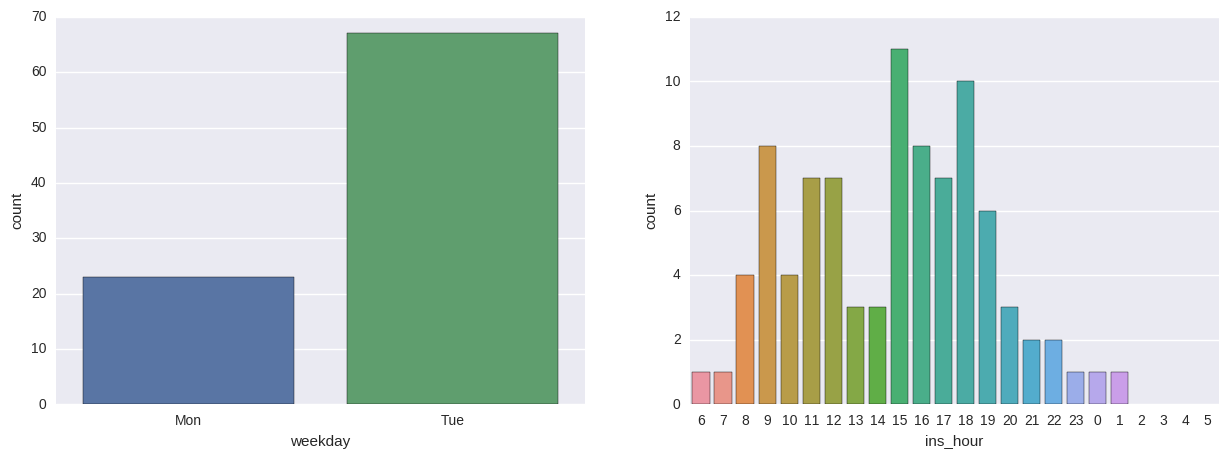

In [15]:
df['aux'] = pd.to_datetime(df['insert_time'])
df['weekday']=df['aux'].apply(lambda x:x.weekday())
df['ins_hour']=df['aux'].apply(lambda x:x.hour)
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='weekday',data=df,ax=ax)
ax.xaxis.set_ticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
sns.countplot(x='ins_hour',data=df,ax=bx,order=np.roll(range(0,24),-6))

Max surface: 66.0
Min surface: 25.0
Min price: 550.0


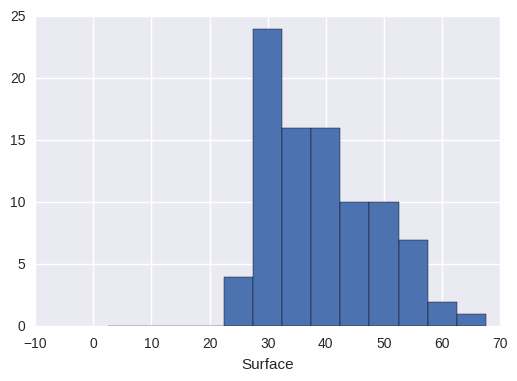

In [17]:
print 'Max surface:',df.Surface.max()
print 'Min surface:',df.Surface.min()
print 'Min price:',df.LoyerMensuel.min()
sns.plt.hist(df.Surface.tolist(),bins=np.arange(0-2.5,int(df.Surface.max())+2.5,5))
sns.plt.xlabel('Surface');


## work out some new columns
- **Binning price by 250€**
- **Binnig surface by 5 m<sup>2</sup>**

In [18]:
i = [10,15,20,25,30,35,40]
o = sns.np.digitize(i,bins=sns.np.arange(0,130,5))
print 'Surface binning legend'
for p,q in zip(i,o):
    print p,'sqm -> #',q

Surface binning legend
10 sqm -> # 3
15 sqm -> # 4
20 sqm -> # 5
25 sqm -> # 6
30 sqm -> # 7
35 sqm -> # 8
40 sqm -> # 9


In [19]:
#######################################################################
df['price_bin']=sns.np.digitize(df.LoyerMensuel,bins=sns.np.arange(0,21*250,250))
df['sqm_bin'] = sns.np.digitize(df.Surface,bins=sns.np.arange(0,130,5))
df['price_sqm'] = df.LoyerMensuel/df.Surface
df = df[(df['price_sqm'] < 200)]
#######################################################################
mapges2int={'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'I':9,'N':10,'V':11,'X':12}
def safe_ges(x):
    try:
        return x.strip()[0]
    except AttributeError:
        return 'X'
    
df['Ges_lit']=df['Ges'].apply(safe_ges)
df['Ges_int']=df['Ges_lit'].apply(lambda x:mapges2int[x])
########################################################################
df['ClasseEnergie_lit']=df['ClasseEnergie'].apply(safe_ges)
df['ClasseEnergie_int']=df['ClasseEnergie_lit'].apply(lambda x:mapges2int[x])
########################################################################
dfCC=df[df['ChargesComprises']==1]
dfNC=df[df['ChargesComprises']==0]
df=dfCC
########################################################################
def sistema_arrondissement(x):
    if x>100:
        return int(x-100)
    else:
        return int(x)
df['Arrondissement']=df['Arrondissement'].apply(sistema_arrondissement)
########################################################################
# sorting by average price per arrondissement 
def mean_outliers(x):
    _m = x.mean()
    _v = x.std()
    return x[(x>_m-_v) & (x<_m+_v)].mean()

sorted_district_by_aveprice = []
__tmp = []
for c in df.groupby('Arrondissement'):
#     __tmp.append((c[0],c[1].price_sqm.mean()))
    __tmp.append((c[0],mean_outliers(c[1].price_sqm)))

__tmp = np.asarray(__tmp)
__sidx = np.argsort(__tmp[:,1])
sorted_district_by_aveprice = __tmp[__sidx][:,0]
sorted_district_by_aveprice_labels = ['%d'%j for j in sorted_district_by_aveprice]
sorted_ges_labels = sorted(list(df['Ges_lit'].unique()))
#######################################################################
df['Meuble_int']=df['Meuble'].apply(safe_conv_pos_int)
#######################################################################

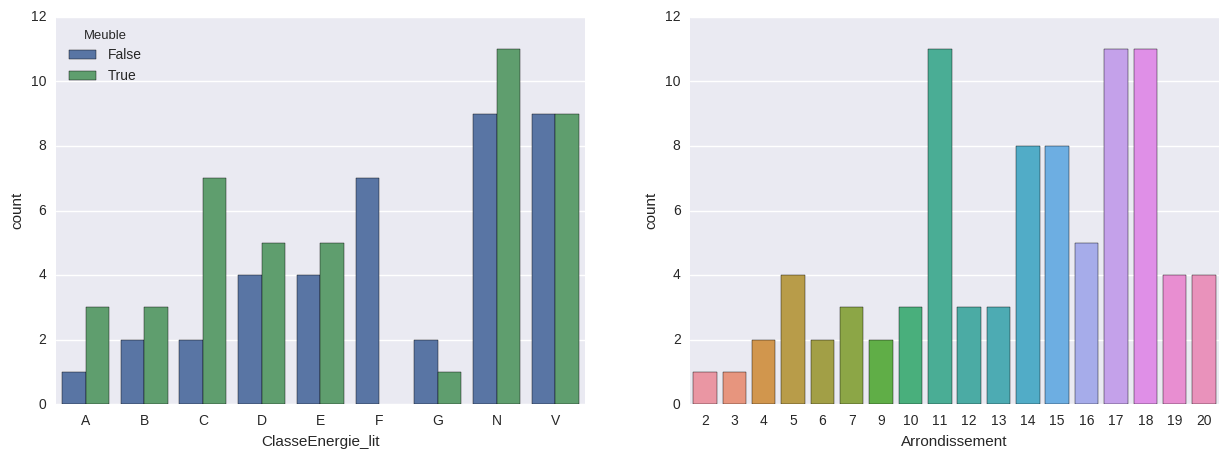

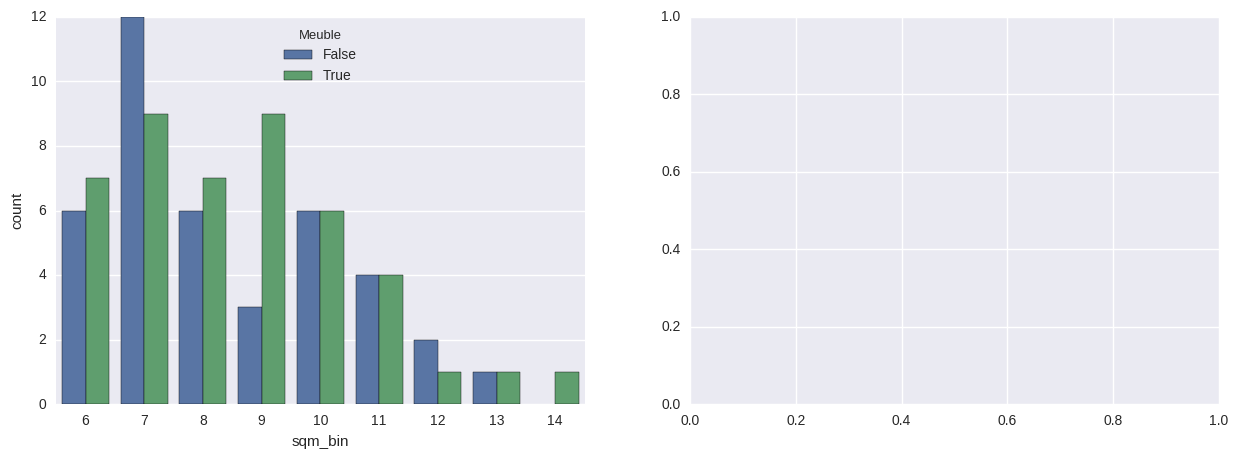

In [20]:
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='ClasseEnergie_lit',data=df,order=sorted_ges_labels,hue='Meuble',ax=ax)
sns.countplot(x='Arrondissement',data=df,ax=bx)
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='sqm_bin',data=df,hue='Meuble',ax=ax)

Remember that the surface nad price bins are:
- Surface bin: 5 m<sup>2</sup>
- Price bin  : 250 Eu

In [21]:
sqm_bin_palette=sns.cubehelix_palette(9, start=1, rot=.1)
# sns.palplot(sqm_bin_palette)

##########################################################################################
* color code by sqm_bin too should give the trend of the 1st plot
* # of records 86
                  /20 4.3
                  /15 5.73333333333
##########################################################################################


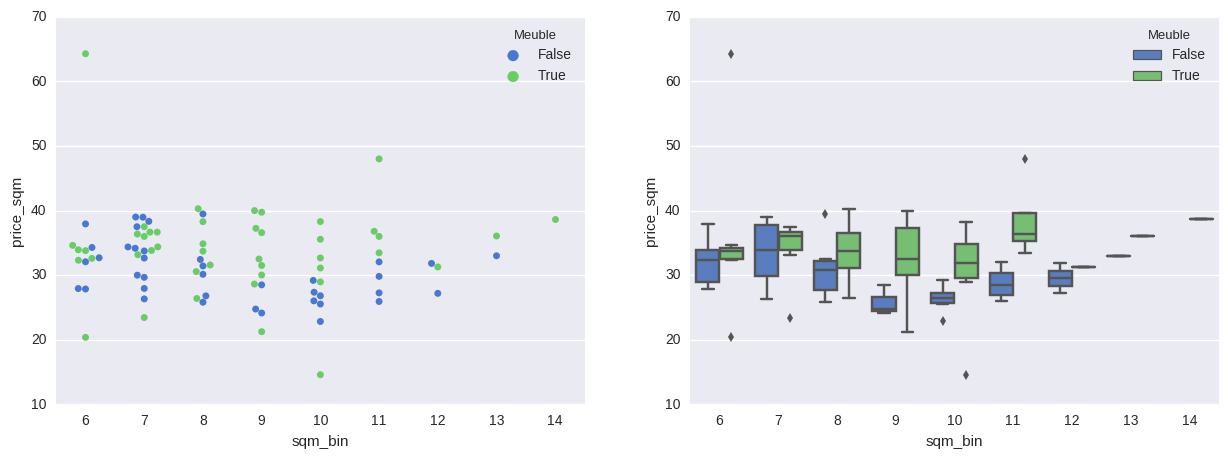

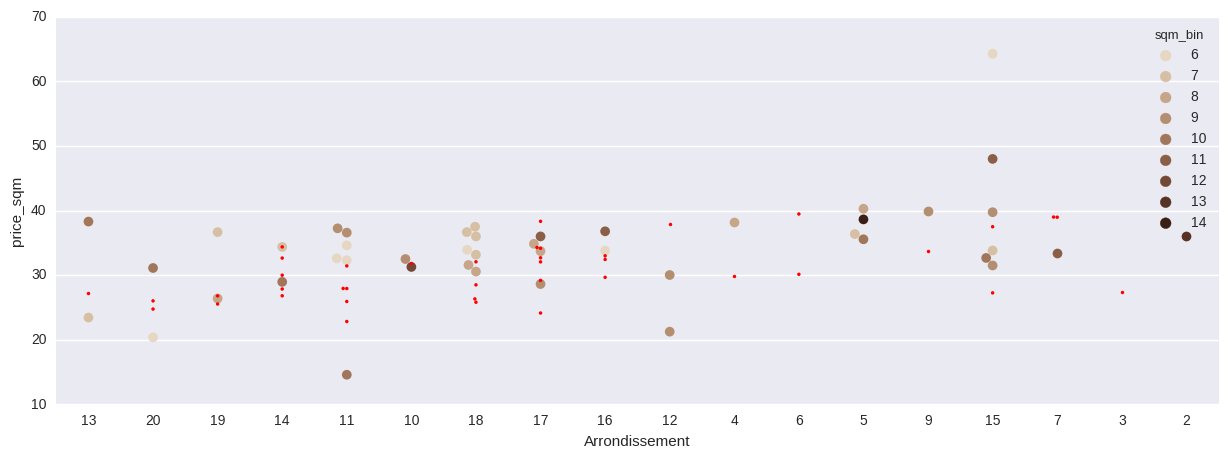

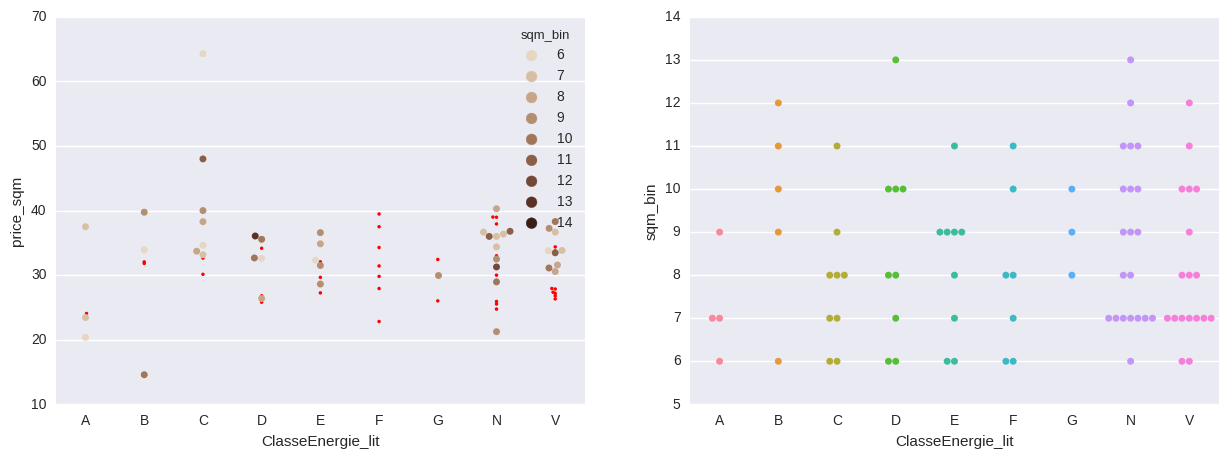

In [22]:
sns.set_palette('muted')
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.swarmplot(x='sqm_bin',y='price_sqm',data=dfCC,ax=ax,palette='muted',hue='Meuble')
sns.boxplot(x='sqm_bin',y='price_sqm',data=dfCC,hue='Meuble',ax=bx);
#####################################################################
# fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
# sns.swarmplot(x='sqm_bin',y='price_sqm',data=dfCNC,ax=ax,palette='muted')
# sns.boxplot(x='sqm_bin',y='price_sqm',data=dfCNC,hue='Meuble',ax=bx);
# #####################################################################
# fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
# sns.boxplot(y='sqm_bin',x='Arrondissement',data=dfCC,ax=ax)
# _=ax.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
# sns.boxplot(y='sqm_bin',x='Arrondissement',data=dfCC,hue='Meuble',ax=bx);
# _=bx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
#####################################################################
# fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
# sns.boxplot(y=u'price_sqm',x=u'Arrondissement',data=df,order=sorted_district_by_aveprice,ax=ax)
# _=ax.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
# sns.boxplot(y=u'price_sqm',x=u'ClasseEnergie_lit',data=df,order=sorted_ges_labels,ax=bx)
# #####################################################################
fig,ax=sns.plt.subplots(1,1,figsize=(15,5))
sns.swarmplot(y=u'price_sqm',x=u'Arrondissement',data=df[df['Meuble']==True],order=sorted_district_by_aveprice,\
              ax=ax,size=7,palette=sqm_bin_palette,hue='sqm_bin')
sns.swarmplot(y=u'price_sqm',x=u'Arrondissement',data=df[df['Meuble']==False],order=sorted_district_by_aveprice,ax=ax,\
              size=2.5,color='#ff0000')

_=ax.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
# # #####################################################################
# fig,ax=sns.plt.subplots(1,1,figsize=(15,5))
# sns.tsplot(data=df, time="Arrondissement", unit="price_sqm",ax=ax)

#####################################################################
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
sns.swarmplot(y=u'sqm_bin',x=u'ClasseEnergie_lit',data=dfCC,order=sorted_ges_labels,ax=bx)
sns.swarmplot(y=u'price_sqm',x=u'ClasseEnergie_lit',data=dfCC[dfCC['Meuble']==False],order=sorted_ges_labels,ax=ax,\
              size=2.5,color='#ff0000')
sns.swarmplot(y=u'price_sqm',x=u'ClasseEnergie_lit',data=dfCC[dfCC['Meuble']==True],order=sorted_ges_labels,ax=ax,\
             palette=sqm_bin_palette,hue='sqm_bin');
#####################################################################
line="#"*90
print line
print '* color code by sqm_bin too should give the trend of the 1st plot'
print '* # of records',df.shape[0]
print '                  /20',df.shape[0]/20.
print '                  /15',df.shape[0]/15.
print line

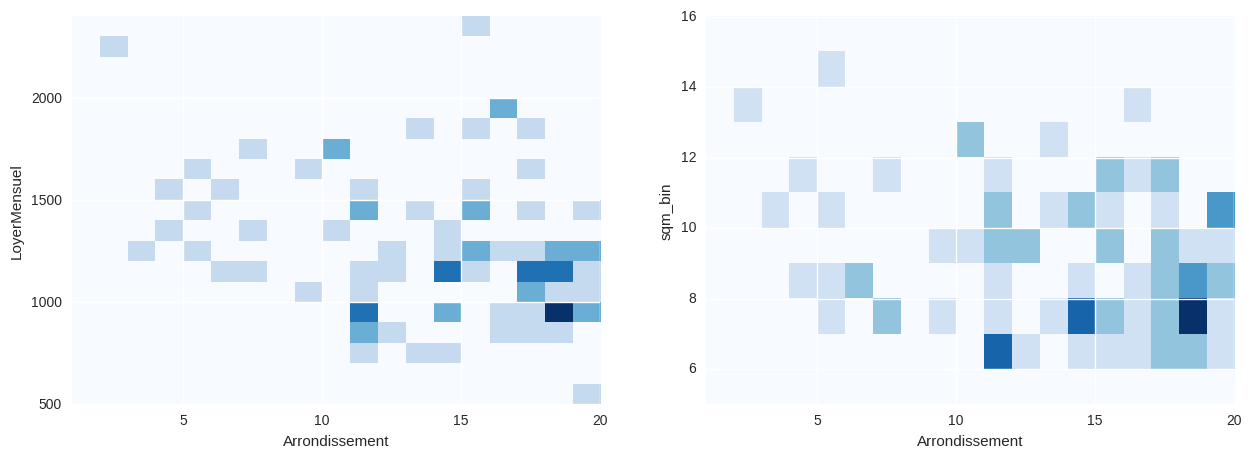

In [23]:
fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
ax.hist2d(df['Arrondissement'],df['LoyerMensuel'],cmap='Blues',bins=[range(1,21),range(500,2500,100)]);
bx.hist2d(df['Arrondissement'],df['sqm_bin'],cmap='Blues',bins=[range(1,21),sns.plt.np.arange(5,17)]);
ax.set_xlabel('Arrondissement')
ax.set_ylabel('LoyerMensuel')
bx.set_xlabel('Arrondissement')
bx.set_ylabel('sqm_bin')

## PCA the data, svp

In [24]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import Normalizer

careof = ['price_sqm','Meuble','Surface','ClasseEnergie_int','Arrondissement']
df2 = df[(df.ClasseEnergie_lit != 'V') & (df.ClasseEnergie_lit != 'N') & (df.ClasseEnergie_lit != 'X')]
X = df2[careof].dropna()
normalizer = Normalizer()
Xa = normalizer.fit_transform(sns.np.array(X,dtype=float))

In [25]:
pca = PCA(n_components=3)
pca.fit(Xa)
X_r = pca.transform(Xa)
print Xa[1]

[ 0.56573726  0.01731849  0.77933195  0.06927395  0.25977732]


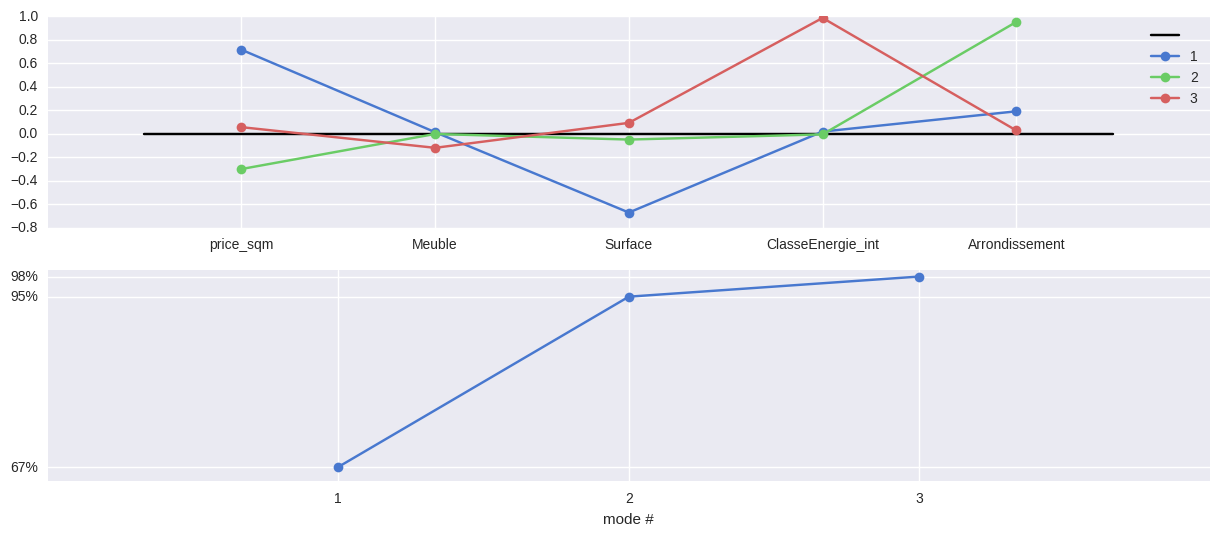

In [28]:
cols = X.columns
ncols = len(cols)
modes = pca.explained_variance_ratio_
nmodes = len(modes)
f,(ax,bx)=sns.plt.subplots(2,1,figsize=[15,6])
ax.plot([-.5,ncols-.5],[0,0],'-k')

ax.plot(pca.components_.T,'-o')
ax.xaxis.set_ticks(range(ncols))
ax.xaxis.set_ticklabels(cols)
ax.set_xlim(-1,ncols)

bx.plot(range(1,nmodes+1),np.cumsum(modes*100),'-o')
bx.set_xlim(0,nmodes+1)
bx.xaxis.set_ticks(range(1,nmodes+1))
bx.yaxis.set_ticks(np.cumsum(modes*100))
bx.yaxis.set_ticklabels(['%d%%'%j for j in np.cumsum(modes*100)])
bx.set_xlabel('mode #')
_=ax.legend(' 123')

Thus the PCA does not see the correlation between price/sqm and furnished flats ?!

In [29]:
def saveapply(x):
    try:
        x=x.replace(u'č',u'è')
        x=x.replace(u'ŕ',u'à')
        return unidecode.unidecode(x)
    except:
        return x
    
def removeshort(x):
    symbols='\'~!@#$%^&*()_+`-=[]\{}|;:"<>?,./'
    try:
        for j in symbols:
            x=x.replace(j,' ')
        return ' '.join([j for j in x.split() if len(j)>3])
    
    except:
        return x

In [31]:
import cPickle as cpk
with open('data/metroParis.pkl','rb') as fin:
    metros = cpk.load(fin)

In [32]:
Mstat = set([unidecode.unidecode(j[0]) for j in metros])

In [33]:
# import json

In [34]:
# with open('data/positions-geographiques-des-stations-du-reseau-ratp.json','r') as fin:
#     ratpinfo=json.load(fin)

IOError: [Errno 2] No such file or directory: 'data/positions-geographiques-des-stations-du-reseau-ratp.json'

In [35]:
# def getratprecord(data,idx,what = [u'stop_name',u'coord']):
#     root = u'fields'
#     out= [data[idx][root][j] for j in what]
#     for i,j in enumerate(out):
#         try:
#             out[i]=unidecode.unidecode(j)
#         except:
#             pass
#     return out

# tmp = [getratprecord(ratpinfo,i) for i in xrange(len(ratpinfo))][:20]


NameError: name 'ratpinfo' is not defined

##  Pdf

In [37]:
import qgrid
# qgrid.nbinstall(overwrite=True)

### Flats above median
What's the probability a flat has a price given it's features?

There is still to few data to compute $\int\, dprice\_sqm price\_smq\, P(price\_sqm|Arr,Meuble,sqm)$, so I use the simpler conditional probabilities $P(Arr,Meuble)$ or $P(Arr,sqm)$ that need less classes.

A similar analysis can be tried with a ``naive Bayes`` or a ``logit`` model.. TODO


In [39]:
df['Arr_Meu_cls']=0
df['Arr_Sqm_cls']=0
def average_flat(to):
    def f(group):
        mean_price = group.price_sqm.median()
        group[to] [group.price_sqm>mean_price]=1
    #     group.Arr_meu_cls = group.price_sqm>mean_price.astype(int)
        return group
    return f


df = df.groupby(('Arrondissement','Meuble')).apply(average_flat('Arr_Meu_cls'))
df = df.groupby(('Arrondissement','sqm_bin')).apply(average_flat('Arr_Sqm_cls'))
careof = careof = ['LoyerMensuel','Surface','price_sqm','Arrondissement','Meuble','ClasseEnergie_lit','url']
qgrid.show_grid(df[df.Arr_Meu_cls>0][careof])
print df[df.Arr_Meu_cls>0].shape[0]*1./df.shape[0]
    

0.406976744186


In [40]:
# careof = ['LoyerMensuel','Surface','price_sqm','Arr_Meu_cls','Arr_Sqm_cls','Arrondissement','Meuble','sqm_bin','url']
# min_surf = 7
# max_surf = 10+1
# ifs=(df['sqm_bin']<max_surf) & (df['sqm_bin']>min_surf) & (df['ClasseEnergie_lit'] == 'C')

# qgrid.show_grid(df[ifs][careof].sort_values('sqm_bin'))

# Average price for 2 ppl
Since the `price` of a flat must be smaller than 1/3 of what ppl gain (in couple),
we get also the distribution of salaries expected for ppl living in paris:
$ price < (salary_1 + salary_2)/3 $
assuming that $salary_1=salary_2$ (bcs of high education jobs), we get $salary_1 > 3/2 price$

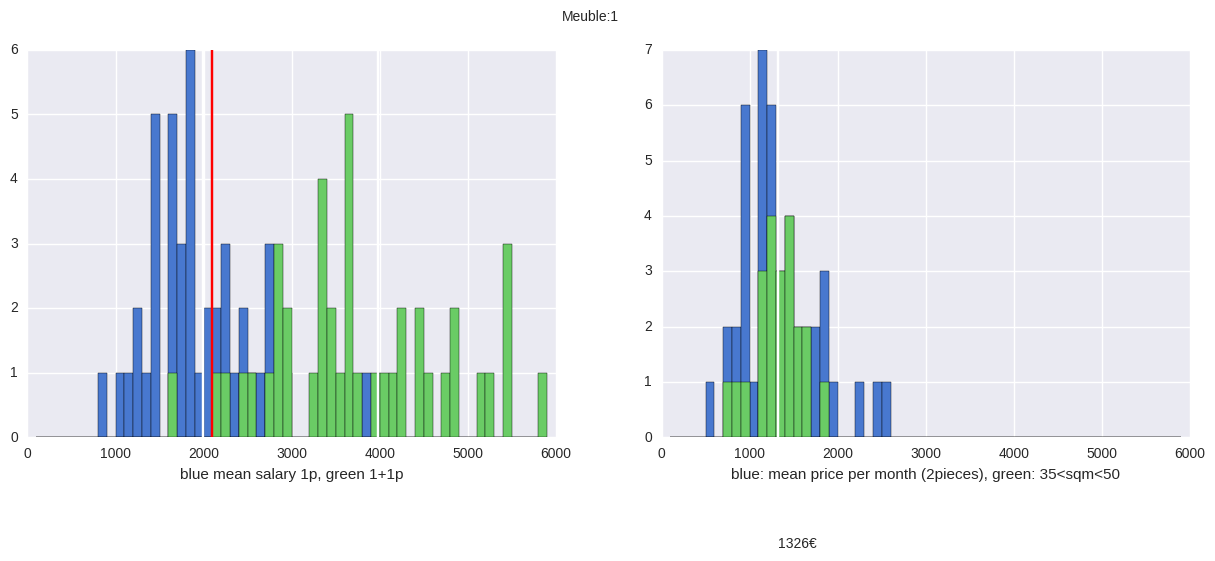

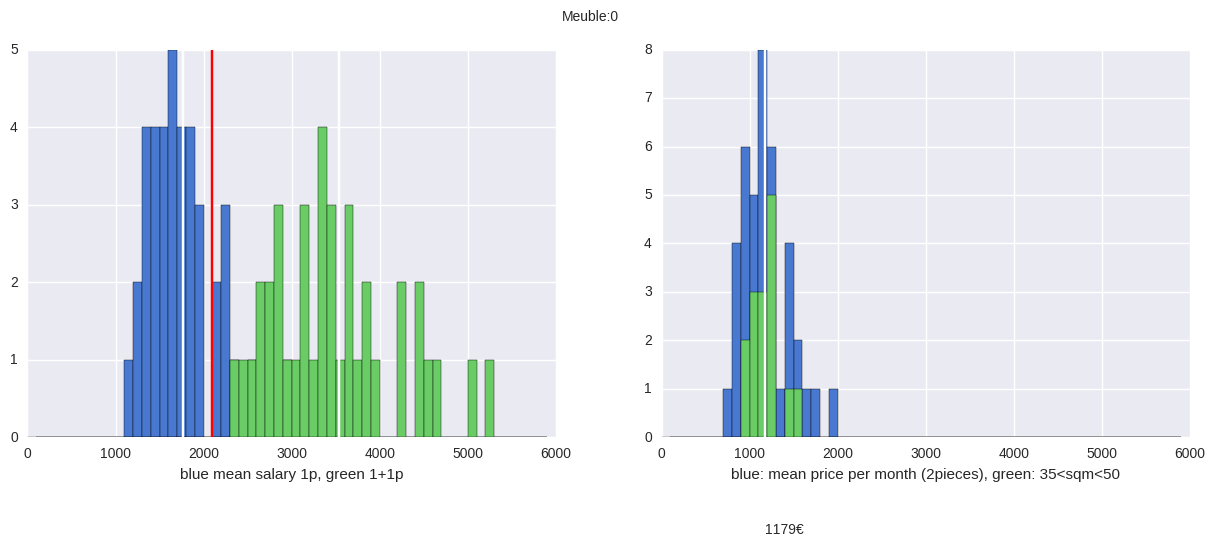

In [41]:
def plot_salaries(df,Meuble=0):
    fig,(ax,bx)=sns.plt.subplots(1,2,figsize=(15,5))
    ifs =  (df.Meuble==Meuble)
    salary1 = df[ifs].LoyerMensuel.values*3/2.
    bins = range(0,6000,100)
    ax.hist(salary1,bins=bins);
    ax.axvline(salary1.mean(),color='w')
    ax.axvline(2100,color='r')
    ax.hist(salary1*2,bins=bins);
    ax.axvline(salary1.mean()*2,color='w')
    ax.set_xlabel('blue mean salary 1p, green 1+1p')

    mean_price_per_month = df[ifs].LoyerMensuel.values.mean()
    price_per_month = df[ifs].LoyerMensuel.values

    min_surf = 7
    max_surf = 10+1
    ifs=ifs & (df['sqm_bin']<max_surf) & (df['sqm_bin']>min_surf) 

    price_per_month_select = df[ifs].LoyerMensuel.values
    bx.hist(price_per_month,bins=bins);
    bx.hist(price_per_month_select,bins=bins);
    bx.axvline(mean_price_per_month,color='w')
    bx.set_xlabel('blue: mean price per month (2pieces), green: 35<sqm<50' )
    bx.text(mean_price_per_month,-2,u'{0:.0f}€'.format(mean_price_per_month),)
    fig.suptitle('Meuble:{0:d}'.format(Meuble))

plot_salaries(df,1)
plot_salaries(df,0)

In [42]:
#PCA when we will have enough data
numeric=['Arrondissement','price_bin','sqm_bin','price_sqm','ClasseEnergie_int','Meuble_int','Pieces']
count = 1
for ix,(i,j) in enumerate(zip(df.columns,df.dtypes)):
    if '64' in str(j):
        classes = len(df[i].unique())
        print "{0:2d} {1:20s} {2:10s} {3:4d}".format(count,i,j,classes)
        count += 1
print 
print 'available measures/available conf space:', len(df)/(20*18*11*10*9.*3)*100,'%'


 1 Arrondissement       float64      19
 2 LoyerMensuel         float64      62
 3 Pieces               float64       2
 4 Surface              float64      31
 5 aux                  datetime64[ns]   84
 6 weekday              float64       3
 7 ins_hour             float64      21
 8 price_bin            float64      10
 9 sqm_bin              float64      10
10 price_sqm            float64      82
11 Ges_int              float64      10
12 ClasseEnergie_int    float64      11
13 Meuble_int           float64       3
14 Arr_Meu_cls          float64       3
15 Arr_Sqm_cls          float64       3

available measures/available conf space: 0.00804339693229 %


## Mapping 

In [43]:
# Download shapes of paris arrondissements
!wget -c https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements/75/communes.geojson -O data/75.geojson

--2017-01-12 21:48:52--  https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements/75/communes.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.0.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7586 (7,4K) [text/plain]
Saving to: ‘data/75.geojson’

data/75.geojson     100%[===================>]   7,41K  --.-KB/s    in 0,003s  

2017-01-12 21:48:52 (2,68 MB/s) - ‘data/75.geojson’ saved [7586/7586]



In [44]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)
import json
import matplotlib as mpl
with open('data/75.geojson') as f:
    data = json.load(f)

In [45]:
def Gnormalize(x):
    """
        normalizes the 1D array/list x to be between 0. and 1.
    """
    x = sns.plt.np.asarray(x)
    x = x.copy()
    x-=x.min()
    x/=x.max()
    return x

We will assign a colorcode to each arrondissmement, based on the **average price**

In [66]:
from collections import defaultdict
def ddict(x,default=lambda : np.nan):
    """
        returns a default dict with content dict(x)
    """
    out = defaultdict(default)
    out.update(x)
    return out

tmp = []
for c in df[(df.Surface<50) & (df.Meuble_int==1)].groupby('Arrondissement'):
    tmp.append((c[0],mean_outliers(c[1].price_sqm)))

tmp = np.asarray(tmp)
aveprice_prenorm = ddict(tmp)

# normalize prices to compute colors per arrondissmement
tmp=tmp.T
tmp[1]=Gnormalize(tmp[1])

map_palette=sns.diverging_palette(220, 20, n=len(tmp),as_cmap=1)
_ = [(i,mpl.colors.rgb2hex(map_palette(j))) for i,j in tmp.T]
aveprice_color = ddict(_)


# this plot shows that the color map works perfectly!! 
# sns.plt.scatter(tmp[0],tmp[1],lw=0,s=40,color=map_palette(tmp[1]))

In [67]:
# flats_per_arrondissement = []
# for j in df[df['Surface']<50].groupby('Arrondissement'):
#     flats_per_arrondissement.append([ float(j[0]),len(j[1])])
# flats_per_arrondissement = np.asarray(flats_per_arrondissement)
# flats_per_arrondissement[:,1] = Gnormalize(flats_per_arrondissement[:,1])
# flats_per_arrondissement = dict(flats_per_arrondissement)

In [69]:
for j,feature in enumerate(data['features']):
    where = atof(feature['properties']['code'])-75100
    price = aveprice_prenorm[where]
    if not price:
        continue
#     price = flats_per_arrondissement[where]
    color = aveprice_color[where]
    
    feature['properties']['style'] = {'color':color, 'weight': .5, 'fillColor':color, 'fillOpacity':0.75}
    feature['properties']['district']='Arrondissement: {0:.0f}, price: {1:.0f}eu/sqm'.format(where,price)

layer = GeoJSON(data=data, hover_style={'fillOpacity': 1})

def hover_handler(event=None, id=None, properties=None):
    sys.stdout.write("\r" + properties['district'])
    sys.stdout.flush()
    
center = [48.85906816414895, 2.343006134033203]
zoom = 13
m = Map(center=center, zoom=zoom)
layer.on_hover(hover_handler)
m.add_layer(layer)
m.height='500px'
print 'price per sqm (<50smq, meuble\') per district'
print 'You need to run the notebook to see the map :/' 
m

price per sqm (<50smq, meuble') per district
You need to run the notebook to see the map :/
Arrondissement: 7, price: naneu/sqmm

## Styling

In [70]:
from IPython.display import HTML
import urllib2

style=open('style.css','r').read()
HTML("""
<style>{0}</style>
""".format(style))